In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
# поменяйте путь к файлу
reviews_train = load_files("C:\projects\Python\mlcourse_open\Lesson4\data\IMDB/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [5]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [6]:
# поменяйте путь к файлу
reviews_test = load_files("C:\projects\Python\mlcourse_open\Lesson4\data\IMDB/test")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]



## Простой подсчет слов

### Составим словарь всех слов с помощью CountVectorizer.


In [7]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

### Посмотрим на примеры полученных "слов" (лучше их называть токенами). Видим, что многие важные этапы обработки текста мы тут пропустили.

In [8]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


### Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.

In [11]:
X_train = cv.transform(text_train)


In [12]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [13]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150, 66562])

In [14]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150, 66562]))

In [15]:
X_test = cv.transform(text_test)

### Обучим логистическую регрессию

In [23]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

Wall time: 15.6 s


In [24]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.998, 0.86699999999999999)

In [25]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [26]:


def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();



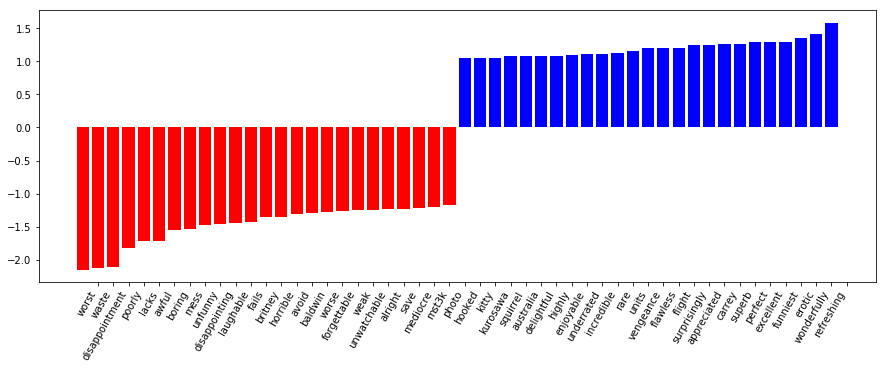

In [27]:
visualize_coefficients(logit, cv.get_feature_names())

### Подберем коэффициент регуляризации для логистической регрессии. 
Используем sklearn.pipeline, поскольку CountVectorizer правильно применять только на тех данных, на которых в текущий момент обучается модель (чтоб не "подсматривать" в тестовую выборку и не считать по ней частоты вхождения слов). В данном случае pipeline задает последовательность действий: применить CountVectorizer, затем обучить логистическую регрессию.

In [28]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

0.8668
Wall time: 29.5 s


In [29]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)



Wall time: 2min 40s


In [30]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.10000000000000001}, 0.88524000000000003)

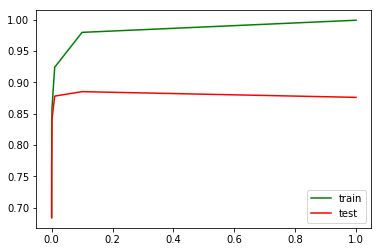

In [31]:
plot_grid_scores(grid_logit, 'logisticregression__C')



In [32]:
grid_logit.score(text_test, y_test)

0.87907999999999997

### Теперь то же самое, но со случайным лесом. Видим, что с логистической регрессией мы достигаем большей доли правильных ответов меньшими усилиями

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [40]:
%%time
forest.fit(X_train, y_train)

Wall time: 1min 43s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [41]:
round(forest.score(X_test, y_test), 3)

0.85499999999999998